# Pryngles module: System

## External modules

In [2]:
#@external
from pryngles import *

import rebound as rb
from tqdm import tqdm
from anytree.util import commonancestors
#@end:external

## System Class

This is the most important class in the whole package.  This class allows to create the planetary system and manipulate it.

In [3]:
#@docstring:System
System_doc=\
f"""Creates a planetary system.

    Initialization attributes:

        units: list of strings, default = ['au','msun','yr2pi']:
            Units used in calculations following the conventions and signs of rebound.
            The order SHOULD always be MKS: length, mass, time (in that order)

    Optional attributes:

        resetable: boolean, default = False:
            If True the system is resetable, namely you can reset it to the initial system.
            
        filename: string, default = None:
            File to load system.

    Derived attributes:

        sim: Class Simulation:
            Rebound Simulation object.

        ul, um, ut: float [SI units]:
            Value of the conversion factors for each unit.

        G: float [ul^3/ut^2/um]
            Value of the gravitational constant.

        bodies: dictionary:
            Bodies in the system.

        nbodies: int:
            Number of bodies.

        nparticles: int:
            Numbre of particles in rebound simulation.

        spangler: Class Spangler:
            Spangler object with all the spangles in the system.

    Examples:

        #Create a system
        sys=System(units=["au","msun","yr"])
        sys.sim.integrator='whfast'
        sys.sim.dt=0.01

        #Add star (by default, m = 1)
        S=sys.add()

        #Add planet, when an object is added, it is automatically spangled
        P=sys.add("Planet",radius=0.1,m=1e-3,a=1,e=0.2)

        #Add moon: orbital elements are respect to ecliptic system
        M=sys.add("Planet",parent=P,radius=0.01,m=1e-7,a=0.1,e=0.01)

        #Add ring system
        R=sys.add("Ring",parent=P,fi=1.5,fe=2.5,albedo_gray_normal=0.5,tau_gray_optical=3)

""";
#@end:docstring

In [4]:
#@class
class System(PrynglesCommon):

    def __init__(self,
                 filename=None,
                 units=['au','msun','yr2pi'],
                 resetable=False
                ):
        
        if filename:
            self.load_from(filename)
            return
        
        #Rebound simulation
        self.sim=None
        self._simulated=False
        
        #Attributes by default
        
        #List of bodies in the system
        self.bodies=odict()
        
        #Root of the tree of bodies
        self.root=None
        
        #Center of the light-source in the system
        self.source=None
        self.center_root=np.array([0,0,0])
        
        #Orbital configuration
        self.orbital_configuration=None
        
        #Observer properties
        self.n_obs=np.array([0,0,1])
        self.alpha_obs=0  
        self.center_obs=None
        
        #Check if spangled
        self._spangled=False
        
        #Check if observer has been set
        self._observer_set=False
        self._luz_set=False
        
        #Initialize spangler object
        self.sg=None
        
        #Is the system resetable?
        self._resetable=resetable
        if self._resetable:
            #Create temporary file
            self._snap_file_name = "/tmp/pryngles-system.pkl"
        
        #Update rebound units
        self.update_units(units)
        
        #By default spangle scatterers
        """
        This is the list of the class of scatterers used to calculate the scattering in
        different types of spangles.
        
        The structure of this dictionary is:
        
            key: integer (or enumerator):
                This is the column spangle_type in the spangler DataFrame.
                
            item: tuple (2):
                Component 1: 
                    Class of scatterer.
                Component 2: 
                    Dictionary mapping the initialization properties of the scatterer to columns
                    in the spangler DataFrame.
        
        Example of item:
        
            SPANGLE_ATMOSPHERIC:(LambertianGrayAtmosphere,dict(AS="albedo_gray_spherical"))
            
                This means that for spangles of the type SPANGLE_ATMOSPHERIC Pryngles will 
                instantiate an object of the class LambertianGrayAtmosphere.  This class have a
                single parameter, the spherical albedo AS.  The dictionary means that when 
                instantiating the object the column "albedo_gray_spherical" will be used to 
                initialize the object.                
        """
        self.spangle_scatterers={
            SPANGLE_ATMOSPHERIC:(LambertianGrayAtmosphere,dict(AS="albedo_gray_spherical")),
            SPANGLE_GRANULAR:(LambertianGraySurface,dict(AL="albedo_gray_normal")),
            SPANGLE_LIQUID:(LambertianGraySurface,dict(AL="albedo_gray_normal")),
            SPANGLE_SOLID_ICE:(LambertianGraySurface,dict(AL="albedo_gray_normal")),
            SPANGLE_SOLID_ROCK:(LambertianGraySurface,dict(AL="albedo_gray_normal")),
            SPANGLE_GASEOUS:(BlackBodySurface,dict()),
            SPANGLE_STELLAR:(BlackBodySurface,dict()),
        }
        
    def update_units(self,units):
        """Update units of the system
        """
        #Check units
        if units[0] not in rb.units.lengths_SI:
            raise ValueError(f"Length unit provided '{units[0]}' is not recognized by Rebound.  Use one of these: {tuple(rb.units.lengths_SI.keys())}")
        if units[1] not in rb.units.masses_SI:
            raise ValueError(f"Mass unit provided '{units[1]}' is not recognized by Rebound.  Use one of these: {tuple(rb.units.masses_SI.keys())}")
        if units[2] not in rb.units.times_SI:
            raise ValueError(f"Time unit provided '{units[2]}' is not recognized by Rebound.  Use one of these: {tuple(rb.units.times_SI.keys())}")
        
        #Units        
        self.units=units
        self._ul,self._um,self._ut=self.units
        #self.sim.units=self.units
        
        #Canonical units of the system
        self.ul=rb.units.convert_length(1,self._ul,"m")
        self.um=rb.units.convert_mass(1,self._um,"kg")

        #Compute the units of time
        sim=rb.Simulation()
        sim.units=self.units
        self.G=sim.G
        self.ut=np.sqrt(self.G*self.ul**3/(self.um*GSI))
        
        #Update system
        self._update_system()
        
    def _get_source(self,body):
        """Get the source of light (stellar body) in the center of a body
        """
        if (body.parent is None) or (body.kind == "Star"):
            return body

        elif body.parent.kind == "Star":
            return body.parent

        else:
            return self._get_source(body.parent)

    def _update_system(self):
        """Update system properties
        """
        self.nbodies=len(self.bodies)
        if self._simulated:
            self.nparticles=len(self.sim.particles)
        
    def _is_spangled(self):
        """Check if system is spangled
        """
        return True if self.sg else False
    
    def reset_state(self):
        """Reset the state of the spangler
        """
        self.sg.reset_state()
        self._observer_set=False
        self._luz_set=False

    def save_to(self,filename):
        """Save system from file
        
        Parameters:
            filename: string:
                Path to file where the object will be pickled.
                
        Result:
            File 'filename' for regular object and 'filename.rbin' for rebound simulation
        """
        if self._simulated:
            #Rebound file
            rb_filename=filename+".rbin"

            #Save rebound state
            verbose(VERB_SIMPLE,"Saving rebound simulation")
            self.sim.save(rb_filename)

            #Since rebound have ctypes it cannot be pickled
            del self.sim
            self._simulated=True

        #Pickle system
        PrynglesCommon.save_to(self,filename)

        if self._simulated:
            #Load again rebound
            self.sim=rb.Simulation(rb_filename)

    def load_from(self,filename):
        """Load system from filename
                
        Parameters:
            filename: string:
                Path to file where the object will be pickled.
                There to be 2 files: 'filename' (with the regular object) and filename.rbin with 
                rebound simulation.
        """
        #Load system
        self=PrynglesCommon.load_from(self,filename)

        if self._simulated:
            #Rebound file
            rb_filename=filename+".rbin"

            #Load rebound
            verbose(VERB_SIMPLE,"Loading rebound simulation")
            self.sim=rb.Simulation(rb_filename)
        
    def status(self):
        if self._simulated:
            print(f"System with {self.nbodies} bodies and {self.nparticles} particles (rings and disk are not particles)")
            self.sim.status()
        else:
            print(f"Simulation for this system has not been yet initialized. Use System.initialize_simulation()")

#@end:class
System.__doc__=System_doc

In [5]:
#@test:system
def test_system_init(self):
    
    global sys

    Verbose.VERBOSITY=VERB_ALL

    sys=System(resetable=True)
    print("Nbodies = ",sys.nbodies)
    print("G constant = ",sys.G)
    print("G constant = ",sys.units)
    print("Canonical units = ",sys.ul,sys.um,sys.ut)

    sys=System(units=['m','kg','s'])
    print("Nbodies = ",sys.nbodies)
    print("G constant = ",sys.G)
    print("G constant = ",sys.units)
    print("Canonical units = ",sys.ul,sys.um,sys.ut)
    print(sys)

    sys.save_to("/tmp/system.pkl")
    print(sys.status())
    sys2=System("/tmp/system.pkl")
    print(sys2.status())

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_system_init=test_system_init
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

.

Nbodies =  0
G constant =  0.9999999999999997
G constant =  ['au', 'msun', 'yr2pi']
Canonical units =  149597870700.0 1.9884754159665356e+30 5022642.89091303
Nbodies =  0
G constant =  6.67408e-11
G constant =  ['m', 'kg', 's']
Canonical units =  1.0 1.0 1.0
{'sim': None, 'bodies': OrderedDict(), 'root': None, 'source': None, 'center_root': array([0, 0, 0]), 'orbital_configuration': None, 'n_obs': array([0, 0, 1]), 'alpha_obs': 0, 'center_obs': None, 'sg': None, 'units': ['m', 'kg', 's'], 'ul': 1.0, 'um': 1.0, 'G': 6.67408e-11, 'ut': 1.0, 'nbodies': 0, 'spangle_scatterers': {2: (<class 'pryngles.scatterer.LambertianGrayAtmosphere'>, {'AS': 'albedo_gray_spherical'}), 4: (<class 'pryngles.scatterer.LambertianGraySurface'>, {'AL': 'albedo_gray_normal'}), 3: (<class 'pryngles.scatterer.LambertianGraySurface'>, {'AL': 'albedo_gray_normal'}), 1: (<class 'pryngles.scatterer.LambertianGraySurface'>, {'AL': 'albedo_gray_normal'}), 0: (<class 'pryngles.scatterer.LambertianGraySurface'>, {'AL': '


----------------------------------------------------------------------
Ran 1 test in 0.117s

OK


In [6]:
#@method:System
def add(self,kind="Star",parent=None,**props):
    """Add an object to the system
    
    Examples:
    
        sys=System()
        S=sys.add("Star",m=2)
    
    Parameters:
    
        kind: string, default = "Star":
            Kind of object: Star, Planet, Ring (see BODY_KINDS).
    
        parent: Body, default = None:
            Parent object of the body.
            
        props: dictionary:
            List of properties of the body.
            
    Returns:
        
        Body
            Body added to the system.
            
    Examples:
        #Add star (by default, m = 1)
        S=sys.add()

        #Add planet, when an object is added, it is automatically spangled
        P=sys.add("Planet",radius=0.1,m=1e-3,x=1,vy=0.2)

        #Add moon: orbital elements are respect to ecliptic system
        M=sys.add("Planet",parent=P,radius=0.01,m=1e-7,a=0.1,e=0.01)

        #Add ring system
        R=sys.add("Ring",parent=P,fi=1.5,fe=2.5,albedo_gray_normal=0.5,tau_gray_optical=3)        
        
    """
    if kind is None:
        raise AssertionError("You must provide a valid object kind (Star, Planet, Ring).")

    if kind not in BODY_KINDS:
        raise ValueError(f"Object kind '{kind}' is not recognized.")

    #Legacy
    if 'primary' in props:
        parent=props["primary"]
    if kind=="Observer":
        parent=self.root
    
    #Default parameters
    if self.root:
        if (kind!="Star") and (parent is None):
            parent=self.root
            
        if kind=="Planet":
            if "m" not in props:
                props["m"]=0.1*parent.m
            if "radius" not in props:
                props["radius"]=0.5*parent.radius
            if "a" not in props:
                if "a" in parent.__dict__:
                    props["a"]=0.5*parent.a
                
    #Create body
    props.update(dict(name_by_kind=True))
    self.__body=eval(f"{kind}(parent=parent,**props)")
    
    if self.__body.name in self.bodies:
        raise ValueError(f"An object with name '{self.__body.name}' has been already added.")
    
    #If we have a root object and no parent has been provided
    if not parent:
        if self.root:
            raise ValueError(f"A root object alread exist in the system ({self.root.name}) and you do not provided a parent body for {self.__body.name}.")
        else:
            self.root=self.__body
            verbose(VERB_SIMPLE,f"Setting the root object as {self.root.name}")
        
    self.bodies[self.__body.name]=self.__body
    
    #Create the shined body tree
    self.__body.shined=[]

    #Update system
    self._update_system()
    
    #Set the source of the object
    if self.__body.source:
        #Check that the source is a body
        if not isinstance(self.__body.source,Body):
            raise ValueError(f"The source of body must be an actual Body.")        
        #Check that the source is among the bodies
        if self.__body.source.name not in self.bodies:
            raise ValueError(f"The source of body {self.__body.name} is not among system bodies {list(self.bodies.keys())}.")
        #Check that the source be a star
        if self.__body.source.kind!="Star":
            raise ValueError(f"The source of body {self.__body.name} must be a Star.  You set {self.__body.source.name} which is a {self.__body.source.kind}.")
        self.__body.source.shined+=[self.__body.name]
    else:
        if self.__body.kind=="Star":
            self.__body.source=self.__body
        elif self.__body.parent==self.root:
            self.__body.source=self.root
        else:
            self.__body.source=self.__body.parent.source
    self.__body.source.shined+=[self.__body.name]
    
    verbose(VERB_SIMPLE,f"Object '{kind}' with name '{self.__body.name}' has been added.")
    return self.__body

#@end:method
System.add=add

In [7]:
#@test:system
def test_system_add(self):

    global sys

    Verbose.VERBOSITY=VERB_SIMPLE
    #Default behavior
    sys=System()
    S=sys.add()
    P=sys.add("Planet")
    M=sys.add("Planet",name="Moon",parent=P)
    print(sys)
    
    #Add to a system
    sys=System()
    S=sys.add(m=8,radius=4)
    P=sys.add("Planet",parent=S,radius=2,a=10)
    M=sys.add("Planet",name="Moon",parent=P,radius=2,a=1)
    R=sys.add("Ring",parent=P,fi=1.3,fe=2.3)
    print(sys)
    print(sys.root)

    #Error
    O=Star()
    self.assertRaises(ValueError,lambda:sys.add("Planet",name="Error1",parent=S,radius=2,a=10,source=1))
    self.assertRaises(ValueError,lambda:sys.add("Planet",name="Error2",parent=P,radius=2,a=1,source=P))
    self.assertRaises(ValueError,lambda:sys.add("Planet",name="Error3",parent=P,radius=2,a=1,source=O))

    #Several sources in a system
    sys=System()
    S1=sys.add(name="Star1",m=8,radius=4)
    S2=sys.add(name="Star2",parent=S1,m=8,radius=4,a=30)
    PS1=sys.add("Planet",name="PlanetS1",parent=S1,radius=2,a=10)
    MPS1=sys.add("Planet",name="Moon",parent=PS1,radius=2,a=1)
    RPS1=sys.add("Ring",parent=PS1,fi=1.3,fe=2.3)
    PS2=sys.add("Planet",name="PlanetS2",parent=S2,radius=2,a=10)
    
    for name in sys.bodies:
        print(name,sys.bodies[name].source.name)
        #print(f"Body {name}:",sys.bodies[name].scatterer)
    
    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_system_add=test_system_add
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

  VERB1::add:: Setting the root object as Star
  VERB1::add:: Object 'Star' with name 'Star' has been added.
  VERB1::add:: Object 'Planet' with name 'Planet' has been added.
  VERB1::add:: Object 'Planet' with name 'Moon' has been added.
{'sim': None, 'bodies': OrderedDict([('Star', <pryngles.body.Star object at 0x7fe77bafa760>), ('Planet', <pryngles.body.Planet object at 0x7fe77bb02d60>), ('Moon', <pryngles.body.Planet object at 0x7fe77bb02d90>)]), 'root': <pryngles.body.Star object at 0x7fe77bafa760>, 'source': None, 'center_root': array([0, 0, 0]), 'orbital_configuration': None, 'n_obs': array([0, 0, 1]), 'alpha_obs': 0, 'center_obs': None, 'sg': None, 'units': ['au', 'msun', 'yr2pi'], 'ul': 149597870700.0, 'um': 1.9884754159665356e+30, 'G': 0.9999999999999997, 'ut': 5022642.89091303, 'nbodies': 3, 'spangle_scatterers': {2: (<class 'pryngles.scatterer.LambertianGrayAtmosphere'>, {'AS': 'albedo_gray_spherical'}), 4: (<class 'pryngles.scatterer.LambertianGraySurface'>, {'AL': 'albedo

.

  VERB1::add:: Setting the root object as Star
  VERB1::add:: Object 'Star' with name 'Star' has been added.
  VERB1::add:: Object 'Planet' with name 'Planet' has been added.
  VERB1::add:: Object 'Planet' with name 'Moon' has been added.
  VERB1::add:: Object 'Ring' with name 'Ring' has been added.
{'sim': None, 'bodies': OrderedDict([('Star', <pryngles.body.Star object at 0x7fe77bafa640>), ('Planet', <pryngles.body.Planet object at 0x7fe77bb02970>), ('Moon', <pryngles.body.Planet object at 0x7fe77bb02b80>), ('Ring', <pryngles.body.Ring object at 0x7fe77bb02af0>)]), 'root': <pryngles.body.Star object at 0x7fe77bafa640>, 'source': None, 'center_root': array([0, 0, 0]), 'orbital_configuration': None, 'n_obs': array([0, 0, 1]), 'alpha_obs': 0, 'center_obs': None, 'sg': None, 'units': ['au', 'msun', 'yr2pi'], 'ul': 149597870700.0, 'um': 1.9884754159665356e+30, 'G': 0.9999999999999997, 'ut': 5022642.89091303, 'nbodies': 4, 'spangle_scatterers': {2: (<class 'pryngles.scatterer.LambertianGra


----------------------------------------------------------------------
Ran 1 test in 0.125s

OK


## Initialize simulation

In [8]:
#@method:System
def initialize_simulation(self,orbital_tree=None,**rebound_options):
    """Initialize rebound simulation using a given orbital tree.
    
    Parameters:
        orbital_tree: list of pairs, default = None:
            A scheme showing how the bodies in the system are organized as in a 
            hierarchical N-body system (see OrbitUtil.build_system).
            
            Examples:
                Simple system: star (S), planet (P):
                    orbital_tree = [S,P]
                
                System with two planets: star (S), planet 1 (P1), planet 2 (P2):
                    orbital_tree = [[S,P1],P2]
                    
                System with moon: star (S), planet (P), moon (M):
                    orbital_tree = [S,[P,M]]
                    
                System with two planets and moons: star (S), planet 1 (P1), moon planet 1 (M), planet 2 (P2):
                    orbital_tree = [[S,[P1,M]],P2]
                    
                System with two stars and one planet per star:
                    orbital_tree = [[S1,PS1],[S1,PS2]]
    
    Return:
        orbit: object Orbit:
            Object containing the hierarchical N-body system.
    
    Update:
        self.sim: Rebound Simulation:
            Simulation of the system.
            
    Note:
    
        You can 
    """
    
    #Compile orbital configuration
    if orbital_tree is None:
        i=0
        for name,body in odict(reversed(list(self.bodies.items()))).items():
            if body == self.root:
                continue
            if body.kind == "Ring":
                continue
            if i == 0:
                self.orbital_tree=body
            else:
                self.orbital_tree=[body,self.orbital_tree]
            i+=1
        self.orbital_tree=[self.root,self.orbital_tree]
    else:
        self.orbital_tree=orbital_tree
    
    #Set the rebound hash of all bodies
    for name,body in self.bodies.items():
        if body.kind=="Ring":
            body.rbhash=body.parent.name
        else:
            body.rbhash=body.name
    
    #Check that all bodies in system is in the orbital tree
    bodies=list(Misc.flatten(self.orbital_tree))
    for name,body in self.bodies.items():
        if body.kind=="Ring":
            continue
        if body not in bodies:
            raise AssertionError(f"Body '{name}' is in System but not in orbital tree.")
        
    #Build hierarchical N-body system
    orbit,pelements=OrbitUtil.build_system(self.orbital_tree,self.units)
    orbit.calculate_orbit()
    
    #Initialize simulation
    self.sim=rb.Simulation()
    self.sim.units=self.units
    
    #Add particles to simulation
    orbit.sim.move_to_com()
    for i,p in enumerate(orbit.sim.particles):
        self.sim.add(
            hash=bodies[i].name,
            m=bodies[i].m,
            x=p.x,y=p.y,z=p.z,
            vx=p.vx,vy=p.vy,vz=p.vz
        )
    self.sim.orbit=orbit
    self._simulated=True
    self._update_system()
    
    return orbit
#@end:method

System.initialize_simulation=initialize_simulation

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
  VERB1::add:: Setting the root object as Star
  VERB1::add:: Object 'Star' with name 'Star' has been added.
      VERB3::_update_childs:: Add child Planet1 to body Star (Star)
      VERB3::_update_parent:: Add parent Star to body Planet (Planet1)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_planet:: Updating Planet
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_planet_properties:: Updating Planet properties
  VERB1::add:: Object 'Planet' with name 'Planet1' has been added.
      VERB3::_update_childs:: Add child Moon1P1 to body Planet (Planet1)
      VERB3::_update_parent:: Add parent Planet1 to body Planet (Moon1P1)
      VERB3::update_body:: Updating Body
      VE

<IPython.core.display.Javascript object>


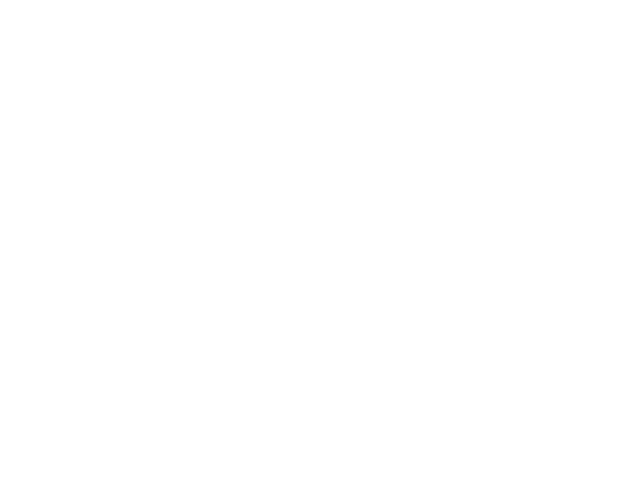

100%|██████████| 100/100 [00:00<00:00, 930.36it/s]
.
----------------------------------------------------------------------
Ran 1 test in 0.541s

OK


In [9]:
#@test:system
def test_sim(self):

    global sys
    plt.close("all")

    Verbose.VERBOSITY=VERB_ALL

    #Create system
    sys=System(units=['au','msun','yr'])
    S=sys.add(m=8,radius=4)
    P1=sys.add("Planet",name="Planet1",parent=S,radius=2,a=1,M=90*Consts.deg,inc=70*Consts.deg)
    M1P1=sys.add("Planet",name="Moon1P1",parent=P1,radius=2,a=0.1)
    R=sys.add("Ring",name="Ring",parent=P1,radius=2)
    P2=sys.add("Planet",name="Planet2",parent=S,radius=2,a=2,M=0*Consts.deg,inc=0*Consts.deg)
    S.show_tree()
    
    #Initialize
    orbit=sys.initialize_simulation(orbital_tree=[[S,[P1,M1P1]],P2])
    sys.sim.status()
    
    #Check save to disk
    sys.save_to("/tmp/system.pkl")
    sys=System()
    sys.load_from("/tmp/system.pkl")
    sys.sim.status()
    
    #Animate
    Plot.animate_rebound(sys.sim,traces=True,axis=True)
    
    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_sim=test_sim
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

## Remove particles

In [10]:
#@method:System
def remove(self,name):
    """Remove a body from a system.

    Parameters:
        name: string
            Hash of the body to remove
    
    Notes: 
        Remove eliminate body and all the childs and the childs of the childs.

    Example:
        sys=System()
        S=sys.add(m=2)
        sys.remove(name=S.name)
    """
    
    if name in self.bodies:
        verbose(VERB_SIMPLE,f"Removing object {name} from system")

        obj=self.bodies[name]

        #Get the list of child hashes before removing (it changes during for)
        child_hashes=list(obj.childs.keys())
        
        #Remove child objects
        for child_hash in child_hashes:
            if child_hash in self.bodies:
                self.remove(child_hash)
                
        #Remove object from Rebound simulation
        if obj.kind != "Ring":
            if self._simulated:
                if self.nparticles:
                    verbose(VERB_SIMPLE,f"Removing particle {name} from simulation")
                    self.sim.remove(hash=name)
        
        #Remove object from childs of its parent
        if obj.parent:
            del obj.parent.childs[name]
        
        #Remove object from bodies
        del self.bodies[name]

        #Update system
        self._update_system()
    else:
        raise ValueError(f"No object with hash '{name}' in the system")
#@end:method
System.remove=remove

In [11]:
#@test:system
def test_system_remove(self):
    
    global sys

    Verbose.VERBOSITY=VERB_ALL

    sys=System()
    S=sys.add(name="Star",m=8,radius=4)
    P=sys.add("Planet",parent=S,name="Planet",radius=2,a=10)
    M=sys.add("Planet",parent=P,name="Moon",radius=2,a=1)
    R=sys.add("Ring",parent=P,name="Ring",fi=1.3,fe=2.3)
    sys.initialize_simulation()
    print(sys.bodies)
    sys.remove("Ring")
    print(sys.bodies)
    sys.remove("Planet")
    print(sys.bodies)
    sys.remove("Star")
    print(sys.bodies)

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_system_remove=test_system_remove
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
  VERB1::add:: Setting the root object as Star
  VERB1::add:: Object 'Star' with name 'Star' has been added.
      VERB3::_update_childs:: Add child Planet to body Star (Star)
      VERB3::_update_parent:: Add parent Star to body Planet (Planet)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_planet:: Updating Planet
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_planet_properties:: Updating Planet properties
  VERB1::add:: Object 'Planet' with name 'Planet' has been added.
      VERB3::_update_childs:: Add child Moon to body Planet (Planet)
      VERB3::_update_parent:: Add parent Planet to body Planet (Moon)
      VERB3::update_body:: Updating Body
      VERB3::_updat

/Users/jorgezuluagacallejas/opt/anaconda3/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: Last particle removed.
  warnings.warn(msg[1:], RuntimeWarning)
.

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_ring:: Updating Ring
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_ring_properties:: Updating Ring properties
  VERB1::add:: Object 'Ring' with name 'Ring' has been added.
OrderedDict([('Star', <pryngles.body.Star object at 0x7fe77bafffd0>), ('Planet', <pryngles.body.Planet object at 0x7fe77baff070>), ('Moon', <pryngles.body.Planet object at 0x7fe77baffa30>), ('Ring', <pryngles.body.Ring object at 0x7fe77baffc40>)])
  VERB1::remove:: Removing object Ring from system
OrderedDict([('Star', <pryngles.body.Star object at 0x7fe77bafffd0>), ('Planet', <pryngles.body.Planet object at 0x7fe77baff070>), ('Moon', <pryngles.body.Planet object at 0x7fe77baffa30>)])
  VERB1::remove:: Removing object Planet from system
  VERB1::remove:: Removing object Moon from system
  VERB1::remove:: Removing partic


----------------------------------------------------------------------
Ran 1 test in 0.316s

OK


## Spangle System, Set Observer and Set Luz

In [12]:
#@method:System
def spangle_system(self):
    """Generate the spangles of the objects in the system
    
    Attributes created:
        
        spanglers: dictionary of Spangler objects:
            Spangler corresponding to each object in the system.
            
        sp: Spangler:
            Spangler corresponding to all system.
            
    Result:
        
        This method create the spangler of the system

    """
    if not self._simulated:
        raise AssertionError("Before spangling the system you must initialize the simulation: System.initialize_simulation().")
    
    self._spanglers=dict()
    
    #Add spangles
    for name,body in self.bodies.items():
        
        verbose(VERB_SIMPLE,f"Spangling body '{name}' (kind '{body.kind}')")
        body.spangle_body()

        #Center object around its position according to rebound
        body.center_ecl=np.array(self.sim.particles[body.rbhash].xyz)
        body.sg.set_positions(center_ecl=body.center_ecl)
        self._spanglers[name]=body.sg
        
    #Set the center of the source of light for each body
    for name,body in self.bodies.items():
        body.center_source=body.source.center_ecl
        if body==self.root:
            self.center_root=body.source.center_ecl
            
    #Join spanglers
    self.sg=Spangler(spanglers=list(self._spanglers.values()))

    #An usefule alias
    self.data=self.sg.data
    
    #Set default observer
    self.update_perspective(n_obs=self.n_obs,alpha_obs=self.alpha_obs)
    
    #Save state of the system
    if self._resetable:
        self.save_to(self._snap_file_name)
    
    #Already spangled
    self._spangled=True

def _set_observer(self,nvec=[0,0,1],alpha=0,center=None):
    """Set the position of the observer
    """
    #Only set observer if it is spangled
    if self._is_spangled():
        
        #At changing the observer, reset state
        self.sg.reset_state()
        
        #Set observer
        self.sg.set_observer(nvec=nvec,alpha=alpha,center=center)
        
        #Update areas of the spangles
        
        #Update system properties
        self.d_obs=self.sg.d_obs
        self.n_obs=self.sg.n_obs.copy()
        self.rqf_obs=self.sg.rqf_obs.copy()
        self.alpha_obs=self.sg.alpha_obs
        self.center_obs=self.sg.center_obs
    
        #Update visibility
        self.sg.update_visibility_state()
        
        #Check that observer has been set
        self._observer_set=True
        
    else:
        raise AssertionError("You must first spangle system before setting observer direction.")
        
def _set_luz_recursive(self,name,nluz,verbosity=VERB_SIMPLE):
    """Set light source for body and 
    """
    body=self.bodies[name]
    verbose(verbosity,f"Illuminating body {name}, with nluz = {nluz} and center = {body.center_source}")
    self.sg.set_luz(nvec=nluz,center=body.center_source,name=name)
    if body.childs:
        verbose(verbosity,f"\tObject {name} has childs!")
        for child_name in body.childs:
            verbose(verbosity,f"\tCalling recursively set_luz for {child_name}")
            self._set_luz_recursive(child_name,nluz)
    else:
        verbose(verbosity,f"\tObject {name} has no childs!")
            
def _set_luz(self,verbosity=VERB_SIMPLE):
    """Set illumination in the system.
    
    Update:
        States: illuminated, shadow, hidden_by_luz
    """
    if self._is_spangled():
        
        if not self._observer_set:
            raise AssertionError("You must first set observer before setting light.")
        
        self.bodies_illuminated=[]
        for name,body in self.bodies.items():
          
            if body.kind == "Star":
                verbose(verbosity,f"Body {body.name} is a star... skipping")
                continue
                
            if body.parent.name in self.bodies_illuminated:
                verbose(verbosity,f"Parent body of {name}, {body.parent.name}, has been already illuminated")
                continue
                        
            #Get center of body
            center=body.center_ecl
                    
            #Get source and center
            verbose(verbosity,f"Calculating illumination for '{name}' coming from '{body.source.name}' @ {body.center_source}")            
            nluz=body.center_source-center
                    
            if body.kind == "Ring" and body.parent.kind == "Star":
                verbose(verbosity,f"Parent body of ring, {body.parent.name} is a star. All spangles will be illuminated")
                self.sg.set_luz(nvec=nluz,center=body.center_source,name=name)
                cond=(self.sg.data.name==name)
                self.sg.data.loc[cond,"unset"]=False
                self.sg.data.loc[cond,"illuminated"]=True
                self.sg.data.loc[cond,"shadow"]=False
            else:                
                verbose(verbosity,f"Illuminating body {name} and all its childs")
                self._set_luz_recursive(name,nluz,verbosity)
                self.sg.update_illumination_state(included=body.source.shined)
                self.bodies_illuminated+=[name]
                
        self._luz_set=True
    else:
        raise AssertionError("You must first spangle system before setting light.")
        
def update_perspective(self,n_obs=None,alpha_obs=0,center_obs=None):
    """Update perspective (observer)
    """
    if n_obs is not None:
        #Update observing conditions
        self.n_obs,one=spy.unorm(n_obs)
        self.alpha_obs=alpha_obs
        self.center_obs=center_obs

    #Set observer
    self._set_observer(nvec=self.n_obs,alpha=self.alpha_obs,center=center_obs)
    self._set_luz()
    
#@end:method

System._set_luz_recursive=_set_luz_recursive
System._set_observer=_set_observer
System._set_luz=_set_luz
System.update_perspective=update_perspective
System.spangle_system=spangle_system

<IPython.core.display.Javascript object>


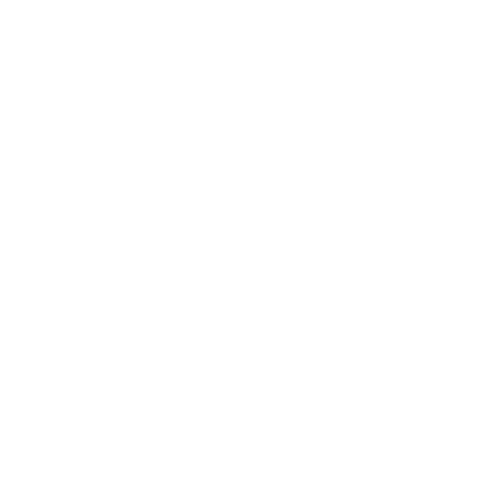

<IPython.core.display.Javascript object>


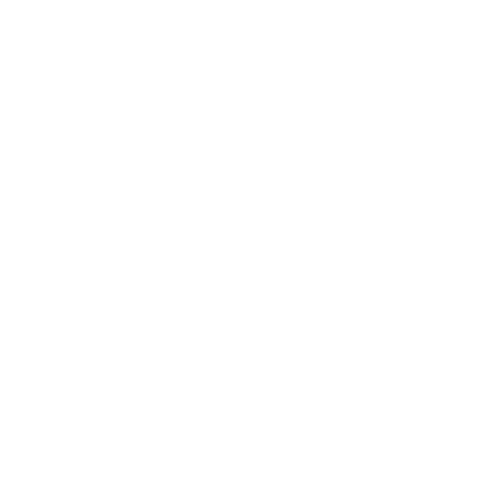

None
Index(['name', 'spangle_type', 'geometry', 'scale', 'n_equ', 'alpha_equ', 'w',
       'q0', 'center_equ', 'x_equ', 'y_equ', 'z_equ', 'r_equ', 'q_equ',
       'f_equ', 'ns_equ', 'center_ecl', 'x_ecl', 'y_ecl', 'z_ecl', 'wx_ecl',
       'wy_ecl', 'ns_ecl', 'center_int', 'x_int', 'y_int', 'z_int', 'ns_int',
       'rho_int', 'az_int', 'cosf_int', 'cos_int', 'azim_int', 'n_int',
       'n_int_ecl', 'd_int', 'asp_int', 'z_cen_int', 'hidden_by_int',
       'transit_over_int', 'string_int', 'center_obs', 'x_obs', 'y_obs',
       'z_obs', 'ns_obs', 'rho_obs', 'az_obs', 'cosf_obs', 'cos_obs',
       'azim_obs', 'n_obs', 'd_obs', 'asp_obs', 'z_cen_obs', 'hidden_by_obs',
       'transit_over_obs', 'center_luz', 'x_luz', 'y_luz', 'z_luz', 'ns_luz',
       'rho_luz', 'az_luz', 'cosf_luz', 'cos_luz', 'azim_luz', 'n_luz',
       'd_luz', 'asp_luz', 'z_cen_luz', 'hidden_by_luz', 'transit_over_luz',
       'azim_obs_luz', 'asp', 'dsp', 'scatterer', 'albedo_gray_normal',
       'albedo_gray_spheric

<IPython.core.display.Javascript object>


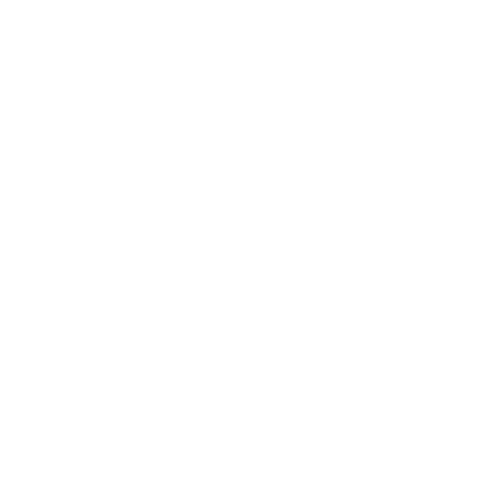

.
----------------------------------------------------------------------
Ran 1 test in 1.437s

OK


In [13]:
#@test:system
def test_spangleobs(self):

    global sys
    plt.close("all")

    Verbose.VERBOSITY=VERB_NONE

    nspangles=100

    #Define system
    sys=System(resetable=True)

    #Add objects
    S=sys.add(nspangles=nspangles,m=8,radius=1)
    P=sys.add("Planet",parent=S,nspangles=nspangles,m=1,radius=0.2,a=5)

    #Test setting observer without spangling
    self.assertRaises(AssertionError,lambda:sys._set_observer(nvec=[1,0,0]))

    #Spangle system
    sys.initialize_simulation()
    sys.spangle_system()

    sys._set_observer(nvec=[-1,0,0])
    sys.sg.plot3d()

    sys._set_observer(nvec=[0,0,1])
    sys.sg.plot3d()
    
    #Spangle with light
    nspangles=100
    sys=System(resetable=False)
    S=sys.add(name="Star",nspangles=nspangles,m=9,radius=1)
    P=sys.add("Planet",parent=S,name="Planet",nspangles=nspangles,radius=0.2,a=2)
    M=sys.add("Planet",parent=P,name="Moon",nspangles=nspangles,radius=0.1,a=1)
    R=sys.add("Ring",parent=P,name="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)

    sys.initialize_simulation()
    sys.spangle_system()

    #Check addition columns
    print(sys.source)
    print(sys.sg.data.columns)

    #Check save
    sys.save_to("/tmp/system.pkl")

    #Check plot
    #sys.sp.plot3d(center_at="Ring",not_plot=["Star1","Star2"])
    sys.sg.plot3d()

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_spangleobs=test_spangleobs
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

<IPython.core.display.Javascript object>


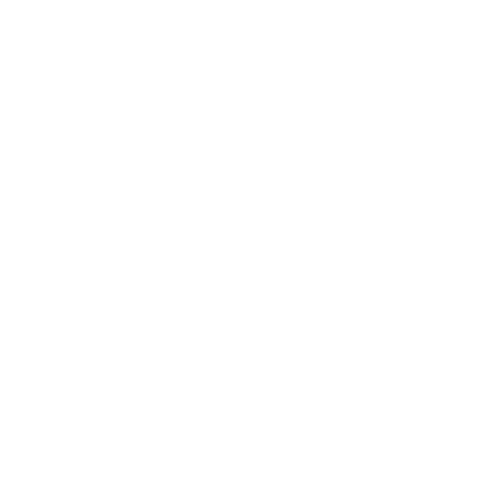

,hidden_by_luz
2197,Ring:-1.036e+01&
2205,Ring:-1.036e+01&
2210,Ring:-1.036e+01&
2218,Ring:-1.036e+01&
2231,Ring:-1.036e+01&
2239,Ring:-1.036e+01&
2244,Ring:-1.036e+01&
2252,Ring:-1.036e+01&
2265,Ring:-1.036e+01&
2273,Ring:-1.036e+01&


.
----------------------------------------------------------------------
Ran 1 test in 4.415s

OK


In [14]:
#@test:system
def test_setluz(self):

    global sys
    plt.close("all")

    Verbose.VERBOSITY=VERB_NONE
    nspangles=500
    sys=System()
    S=sys.add("Star",nspangles=nspangles,m=1,radius=1)
    D=sys.add("Ring",name="Disk",parent=S,nspangles=nspangles,fi=20,fe=30,i=0*Consts.deg)
    P=sys.add("Planet",parent=S,nspangles=nspangles,radius=0.2,m=1e-3,a=10)
    R=sys.add("Ring",parent=P,nspangles=nspangles,fi=1.5,fe=2.0,i=-20*Consts.deg)
    M=sys.add("Planet",parent=P,name="Moon",nspangles=nspangles,radius=0.1,m=1e-6,a=1,M=30*Consts.deg)
    K=sys.add("Ring",name="Cronoring",parent=M,nspangles=nspangles,fi=1.1,fe=1.5,i=20*Consts.deg)
    
    sys.initialize_simulation()
    sys.spangle_system()
    
    sys.sg.plot3d(center_at="Ring",not_plot=["Disk"])
    #sys.sg.plot3d(center_at="Ring")
    #sys.sg.plot3d()
    cond=(sys.sg.data.name=="Moon")&(sys.sg.data.hidden_by_luz!="")
    print_df(sys.sg.data.loc[cond,["hidden_by_luz"]].head(10))

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_setluz=test_setluz
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

<IPython.core.display.Javascript object>


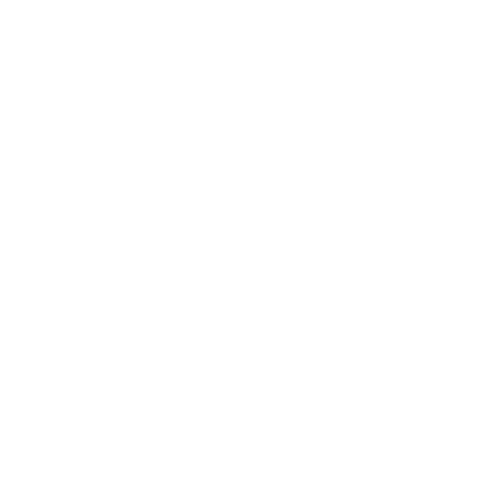

<IPython.core.display.Javascript object>


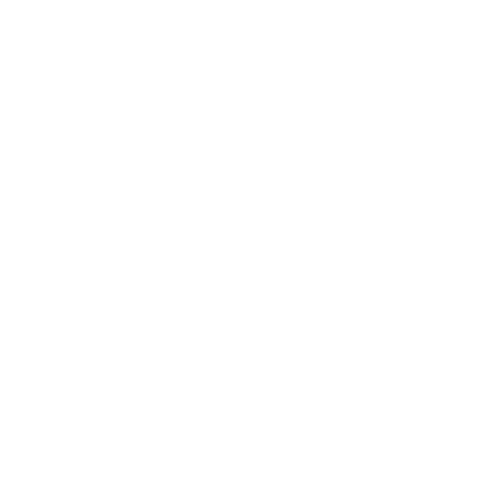

.
----------------------------------------------------------------------
Ran 1 test in 6.138s

OK


In [15]:
#@test:system
def test_setmultiple(self):

    global sys
    plt.close("all")

    Verbose.VERBOSITY=VERB_NONE

    nspangles=500
    sys=System(resetable=False)

    S=sys.add(name="Star",nspangles=nspangles,m=9,radius=1)
    P=sys.add("Planet",parent=S,name="Planet",nspangles=nspangles,radius=0.2,a=3)
    M=sys.add("Planet",parent=P,name="Moon",nspangles=nspangles,m=1e-3,radius=0.1,a=1,M=90*Consts.deg)
    R=sys.add("Ring",parent=P,name="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=60*Consts.deg)

    S2=sys.add(name="Star2",parent=S,nspangles=nspangles,m=9,radius=1,a=10)
    P2=sys.add("Planet",parent=S2,name="Planet S2",nspangles=nspangles,radius=0.2,a=2,M=180*Consts.deg)
    R2=sys.add("Ring",parent=P2,name="Ring2",nspangles=nspangles,fi=1.3,fe=2.3,i=30*Consts.deg)
    M2=sys.add("Planet",parent=P2,name="Moon PS2",nspangles=nspangles,m=1e-3,radius=0.1,a=1,M=205*Consts.deg)

    orbital_tree=[[S,[P,M]],[S2,[P2,M2]]]

    sys.initialize_simulation(orbital_tree)
    sys.spangle_system()

    #Show system from above
    sys.sg.plot2d()

    #Show only Star 2 system
    sys.update_perspective(n_obs=[1,-1,0])
    sys.sg.plot2d(include=["Planet S2","Ring2","Moon PS2"])
    
    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_setmultiple=test_setmultiple
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

### Miscelaneous methods

In [16]:
#@method:System
def update_body(self,body,**props):
    """Update properties of a body in the system
    
    Parameters:
        body: string or Body:
            Body to update
        
        props: dict:
            Dictionary with properties of the object
    """
    #Update spangling?
    if self._is_spangled():
        raise AssertionError("After spangling you cannot update the properties of the bodies.  Please rebuild the system")

    #Update body properties
    if isinstance(body,Body):
        body.update_body(**props)
    elif body in self.bodies:
        body=self.bodies[body]
        lkind=body.kind.lower()
        exec(f"body.update_{lkind}()")
    else:
        raise AssertionError("You are trying to update a body ({body}) which is not in the system")
        
    #Check if among props there is any property related to position
    if any(k in props for k in REBOUND_ORBITAL_PROPERTIES):
        raise ValueError(f"You cannot update an orbital property {props} without compromising the full simulation. Rebuild the system from scratch.")
#@end:method
System.update_body=update_body

In [17]:
#@test:system
def test_update(self):

    Verbose.VERBOSITY=VERB_NONE

    nspangles=100
    sys=System(resetable=True)
    S=sys.add("Star",name="Star",nspangles=nspangles,m=8,radius=1)
    P=sys.add("Planet",parent=S,name="Planet",nspangles=nspangles,radius=0.2,a=2)
    M=sys.add("Planet",parent=P,name="Moon",nspangles=nspangles,radius=0.1,a=1)
    R=sys.add("Ring",parent=P,name="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)
    print(P.radius)
    sys.update_body(P,radius=0.5)
    print(P.radius)
    sys.update_body("Ring",fe=3.0)
    print(R.radius)
    sys.initialize_simulation()
    sys.spangle_system()
    self.assertRaises(AssertionError,lambda:sys.update_body("Ring",fe=3.0))

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_update=test_update
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

0.2
0.5
1.15


.
----------------------------------------------------------------------
Ran 1 test in 0.583s

OK


In [18]:
#@method:System
def reset(self):
    """Reset system to spangling state
    """
    if self._resetable:
        self.load_from(self._snap_file_name)
        pass
    else:
        print("System is not resetable. Use resetable = True when defining the System or when you spangle it.")
#@end:method
System.reset=reset

<IPython.core.display.Javascript object>


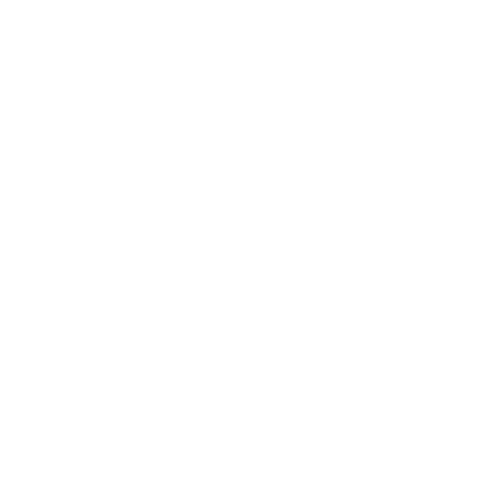

<IPython.core.display.Javascript object>


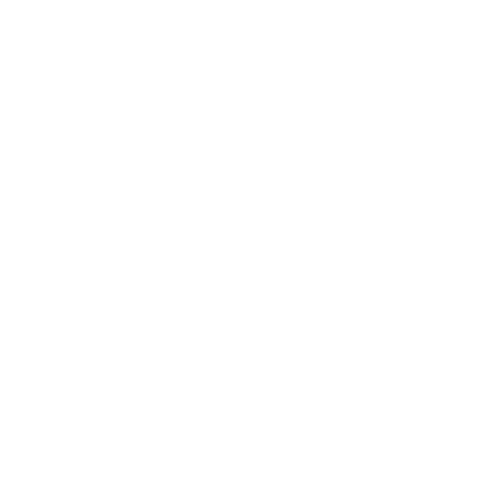

<IPython.core.display.Javascript object>


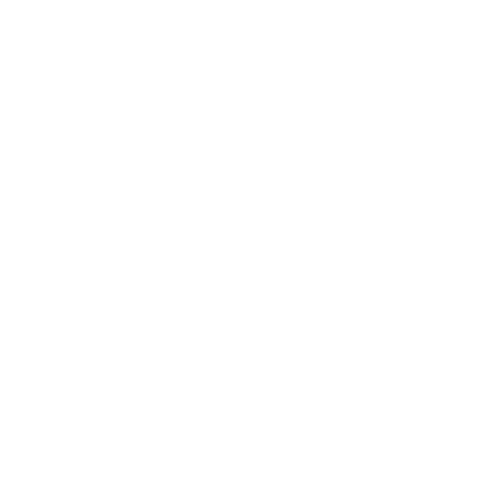

.
----------------------------------------------------------------------
Ran 1 test in 1.323s

OK


In [19]:
#@test:system
def test_reset(self):

    global sys

    Verbose.VERBOSITY=VERB_NONE

    nspangles=100
    sys=System(resetable=True)
    S=sys.add("Star",name="Star",nspangles=nspangles,m=8,radius=1)
    P=sys.add("Planet",parent=S,name="Planet",nspangles=nspangles,radius=0.2,a=2)
    M=sys.add("Planet",parent=P,name="Moon",nspangles=nspangles,radius=0.1,a=1)
    R=sys.add("Ring",parent=P,name="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)
    
    sys.initialize_simulation()
    sys.spangle_system()

    #All transformations from here are not stored
    sys.sg.plot3d()
    sys._set_observer(nvec=[0,0,-1])
    sys.sg.plot3d()

    #All transformations from here are not stored
    sys.reset()
    sys.sg.plot3d()

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_reset=test_reset
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

## Integrate system

In [20]:
#@method:System
def integrate(self,*args,**kwargs):
    """Integrate system

    Parameters:
        *args, **kwargs:
            Mandatory (non-keyword) arguments and optional (keyword) arguments for rebound.integrate.
        
    Update:
        Integrate using integrate rebound method.
        
        Update center of each body and set positions of the spangles.
    """
    #Time of integration
    t=args[0]
    verbose(VERB_SIMPLE,"Integrating up to {t}")
    
    if self._spangled:
        
        #Integrate
        self.sim.integrate(*args,**kwargs)
        self.sim.move_to_com()
    
        #Update positions
        for name,body in self.bodies.items():
            
            #Position of the body according
            body.center_ecl=np.array(self.sim.particles[body.rbhash].xyz)

            verbose(VERB_VERIFY,f"Updating center of body {name} @ {body.center_ecl}")
            cond=self.sg.data.name==name
            self.sg.data.loc[cond,"center_ecl"]=pd.Series([list(body.center_ecl)]*sum(cond),dtype=object).values

        #Update positions
        self.sg.set_positions()
        
    else:
        raise AssertionError("You must first spangle system before setting positions.")
#@end:method
System.integrate=integrate

<IPython.core.display.Javascript object>


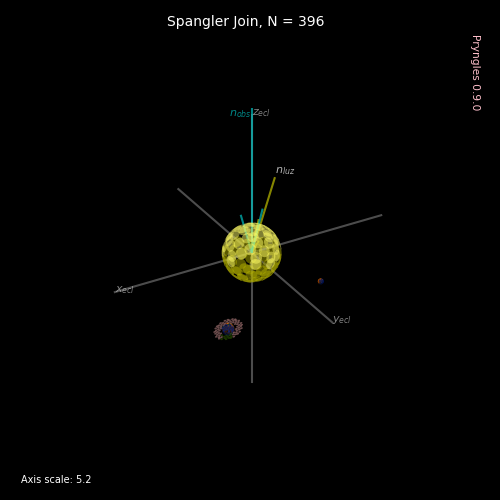

<IPython.core.display.Javascript object>


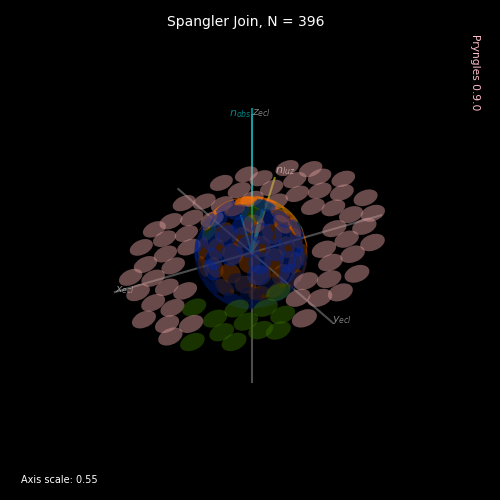

.
----------------------------------------------------------------------
Ran 1 test in 1.120s

OK


In [21]:
#@test:system
def test_int(self):

    global sys
    plt.close("all")

    Verbose.VERBOSITY=VERB_NONE

    nspangles=100
    sys=System()
    S=sys.add("Star",name="Star",nspangles=nspangles,m=1,radius=1)
    M=sys.add("Planet",parent=S,name="Moon",nspangles=nspangles,radius=0.1,m=1e-6,a=3)
    P=sys.add("Planet",parent=S,name="Planet",nspangles=nspangles,radius=0.2,m=1e-3,a=5)
    R=sys.add("Ring",parent=P,name="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=20*Consts.deg)
    
    sys.initialize_simulation([[S,M],P])
    sys.spangle_system()

    sys.integrate(10)

    sys._set_observer([0,0,1])
    sys._set_luz()

    sys.sg.plot3d()
    sys.sg.plot3d(center_at="Ring")

    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_int=test_int
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

## Legacy method

In [22]:
#@consts:system
LEGACY_PHYSICAL_PROPERTIES=dict(
    #Albedos
    AS=1,AL=1,
    #Ring geometrical opacity
    taug=1.0, #Geometrical opacity
    diffeff=1.0, #Diffraction efficiency
    #Law of diffuse reflection on ring surface
    reflection_rings_law=lambda x,y:x,
    #Observations wavelength
    wavelength=550e-9,
    #Ring particle propeties (see French & Nicholson, 2000)
    particles=dict(q=3,s0=100e-6,smin=1e-2,smax=1e2,Qsc=1,Qext=2),
    #Stellar limb darkening
    limb_cs=[],
)
#@end:consts

In [23]:
#@method:System
def ensamble_system(self,lamb=0,beta=0,**physics):
    """Ensamble Ringed Planet
    
    This class is for legacy purposes.
    """
    #Check if observer was provided
    if "Observer" in self.bodies:
        lamb=self.bodies["Observer"].lamb
        beta=self.bodies["Observer"].beta
        
    physics_defaults=deepcopy(LEGACY_PHYSICAL_PROPERTIES)
    physics_defaults.update(dict(limb_cs=self.bodies["Star"].limb_coeffs))
    physics_defaults.update(physics)

    #--CONSISTENCY--
    self._ringedplanet=dict(
        
        #Behavior
        behavior=dict(shadows=True),
        
        #Units
        CU=CanonicalUnits(UL=self.ul,UM=self.um),

        #Basic
        Rstar=self.bodies["Star"].radius,
        Rplanet=self.bodies["Planet"].radius,

        Rint=self.bodies["Ring"].fi,
        Rext=self.bodies["Ring"].fe,
        i=self.bodies["Ring"].i,

        a=self.bodies["Planet"].a,e=self.bodies["Planet"].e,

        #Orbit 
        Mstar=1,x=0,lambq=0,t0=0,kepler=False,

        #Observer
        eobs_ecl=np.array([lamb,beta]),

        #Sampling
        Np=self.bodies["Planet"].nspangles,
        Nr=self.bodies["Ring"].nspangles,

        Nb=0,Ns=30,

        #Physical properties
        physics=physics_defaults,
    )
    self.RP=RingedPlanet(**self._ringedplanet)
    return self.RP

#@end:method
System.ensamble_system=ensamble_system

<IPython.core.display.Javascript object>


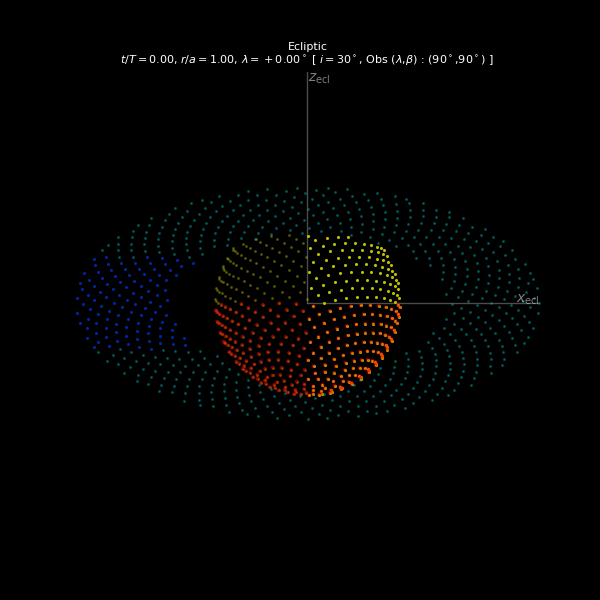

<IPython.core.display.Javascript object>


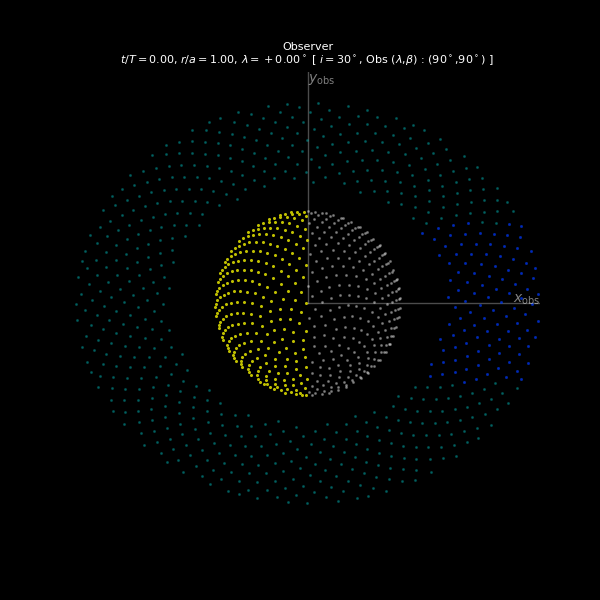

<IPython.core.display.Javascript object>


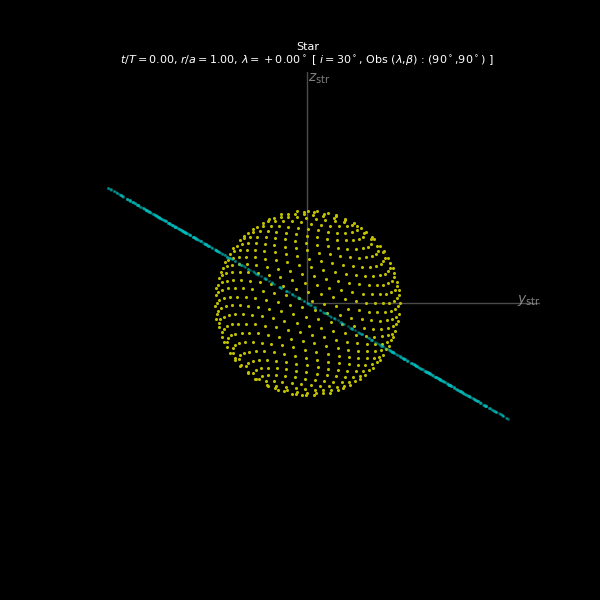

<IPython.core.display.Javascript object>


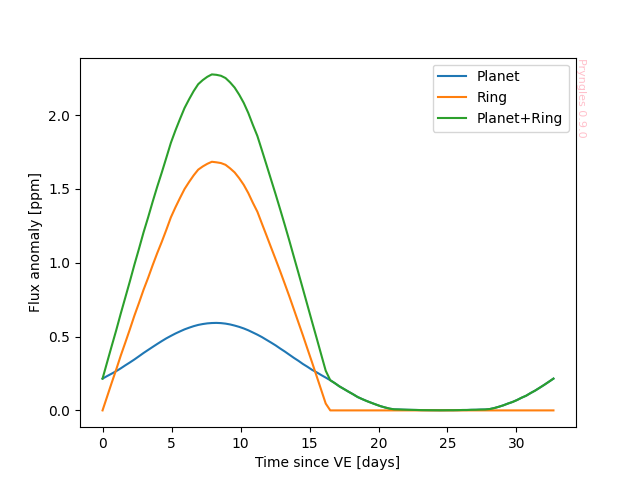

.
----------------------------------------------------------------------
Ran 1 test in 0.646s

OK


In [24]:
#@test:system
def test_legacy(self):

    global sys,RP

    Verbose.VERBOSITY=VERB_NONE
    """
    sys=System()
    S=sys.add(kind="Star",
              physics=dict(radius=Consts.rsun/sys.ul),
              optics=dict(limb_coeffs=[0.65])
             )
    P=sys.add(kind="Planet",primary=S,
              orbit=dict(a=0.2,e=0.0),
              physics=dict(radius=Consts.rsaturn/sys.ul)
             )
    R=sys.add(kind="Ring",primary=P,
              physics=dict(fi=1.5,fe=2.5,i=30*Consts.deg)
             )
    #""";
    
    #"""
    sys=System()
    S=sys.add(kind="Star",radius=Consts.rsun/sys.ul,limb_coeffs=[0.65])
    P=sys.add(kind="Planet",parent=S,a=0.2,e=0.0,radius=Consts.rsaturn/sys.ul)
    R=sys.add(kind="Ring",parent=P,fi=1.5,fe=2.5,i=30*Consts.deg)
    RP=sys.ensamble_system(lamb=90*Consts.deg,beta=90*Consts.deg)
    O=sys.add(kind="Observer",optics=dict(lamb=90*Consts.deg,beta=90*Consts.deg))
    #""";
    
    RP=sys.ensamble_system()
    ecliptic,observer,star=RP.plotRingedPlanet(showfig=1)
    
    RP.changeObserver([90*Consts.deg,30*Consts.deg])

    lamb_initial=+0.0*Consts.deg
    lamb_final=+360*Consts.deg
    lambs=np.linspace(lamb_initial,lamb_final,100)
    Rps=[]
    Rrs=[]
    ts=[]
    for lamb in lambs:
        RP.changeStellarPosition(lamb)
        ts+=[RP.t*RP.CU.UT]
        RP.updateOpticalFactors()
        RP.updateDiffuseReflection()
        Rps+=[RP.Rip.sum()]
        Rrs+=[RP.Rir.sum()]

    ts=np.array(ts)
    Rps=np.array(Rps)
    Rrs=np.array(Rrs)

    #Middle transit
    ts=(ts-ts[0])/Consts.day

    #Plot
    fig=plt.figure()
    ax=fig.gca()    
    ax.plot(ts,1e6*Rps,label="Planet")
    ax.plot(ts,1e6*Rrs,label="Ring")
    ax.plot(ts,1e6*(Rps+Rrs),label="Planet+Ring")

    ax.set_xlabel("Time since VE [days]")
    ax.set_ylabel("Flux anomaly [ppm]")
    Extra.prynglesMark(ax)

    ax.legend();
    
    Verbose.VERBOSITY=VERB_NONE

class Test(unittest.TestCase):pass    
Test.test_legacy=test_legacy
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

### The end

In [25]:
#@end:module

## Playing ground

## Update scatterers

In [26]:
#@method:System
def update_scatterers(self):
    """Update the scatterers of the spangles
    """
    if not self._spangled:
        raise AssertionError("You need to spangle the system before updating the scatterers.")
        
    
    
    pass

#@end:method

System.update_scatterers=update_scatterers

In [30]:
self=sys

In [31]:
sys.spangle_scatterers

{2: (pryngles.scatterer.LambertianGrayAtmosphere,
  {'AS': 'albedo_gray_spherical'}),
 4: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 3: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 1: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 0: (pryngles.scatterer.LambertianGraySurface, {'AL': 'albedo_gray_normal'}),
 5: (pryngles.scatterer.BlackBodySurface, {}),
 6: (pryngles.scatterer.BlackBodySurface, {})}

In [32]:
Scatterer.reset_catalogue()

In [33]:
for i in range(len(self.data)):
    row=self.data.iloc[i]
    st=row["spangle_type"]
    sc,so=sys.spangle_scatterers[st]
    sp=dict()
    for p in so:
        column=so[p]
        sp[p]=row[column]
    sobj=sc(**sp)
    self.data.loc[i,"scatterer"]=sobj.hash

In [27]:
Scatterer.SCATTERERS_CATALOGUE

{}

In [35]:
self.data.scatterer

0       9408234162901871916
1       9408234162901871916
2       9408234162901871916
3       9408234162901871916
4       9408234162901871916
               ...         
2005    9378609292760784128
2006    9378609292760784128
2007    9378609292760784128
2008    9378609292760784128
2009    9378609292760784128
Name: scatterer, Length: 2010, dtype: object

<IPython.core.display.Javascript object>


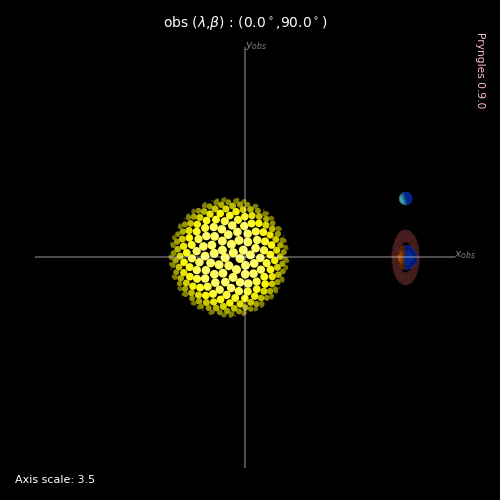

(0, 0)

In [29]:
nspangles=500
sys=System(resetable=False)
S=sys.add(name="Star",nspangles=nspangles,m=9,radius=1)
P=sys.add("Planet",parent=S,name="Planet",nspangles=nspangles,radius=0.2,a=3,spangle_type=SPANGLE_ATMOSPHERIC)
M=sys.add("Planet",parent=P,name="Moon",nspangles=nspangles,m=1e-3,radius=0.1,a=1,M=90*Consts.deg,spangle_type=SPANGLE_LIQUID)
R=sys.add("Ring",parent=P,name="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=60*Consts.deg)
orbital_tree=[S,[P,M]]
sys.initialize_simulation(orbital_tree)
sys.spangle_system()
sys.sg.plot2d()

### Illumination by multiple stars

In [ ]:
nspangles=100
sys=System(resetable=False)

S=sys.add(name="Star",nspangles=nspangles,m=9,radius=1)
P=sys.add("Planet",parent=S,name="Planet",nspangles=nspangles,m=1e-1,radius=0.2,a=5)
M=sys.add("Planet",parent=P,name="Moon",nspangles=nspangles,m=1e-3,radius=0.1,a=1,M=90*Consts.deg)
R=sys.add("Ring",parent=P,name="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)

S2=sys.add(name="Star2",parent=S,nspangles=nspangles,m=9,radius=1,a=10)
P2=sys.add("Planet",parent=S2,name="Planet S2",nspangles=nspangles,radius=0.2,a=2)

sys.initialize_simulation([[S,[P,M]],[S2,P2]])
sys.spangle_system()
sys.update_perspective()

sys.sg.plot2d()

In [ ]:
for sim in Orbit.ORBIT_SIMULATIONS:
    Plot.animate_rebound(sim,traces=True,axis=True)

## Simulate the Sucerquia's effect

In [ ]:
nspangles=1000

sys=System(resetable=False)

S=sys.add(name="Star",nspangles=nspangles,m=1,radius=1)
P=sys.add("Planet",parent=S,nspangles=nspangles,m=1e-3,radius=0.2,a=3)
R=sys.add("Ring",parent=P,nspangles=nspangles,fi=1.3,fe=2.3,i=30*Consts.deg)

sys.initialize_simulation()
sys.spangle_system()

sys.integrate(10)
sys.update_perspective(n_obs=[1,1,1])
sys.sg.plot2d()

In [ ]:
from tqdm import tqdm
for i,t in enumerate(tqdm(np.linspace(0,sys.sim.particles[1].P,20))):
    sys.integrate(t)
    sys.update_perspective()
    if i==0:
        del sys.sg.fig2d
    sys.sg.plot2d(include=["Planet","Ring"],newfig=False)
    #sys.sg.plot2d(newfig=False)
    if i==0:
        camera=Camera(sys.sg.fig2d)
    else:
        camera.snap()

In [ ]:
anim=camera.animate(interval=100,repeat=True,blit=False)
#anim.save("tmp/sucerquia-effect-nostar.gif")
#Image(open("tmp/sucerquia-effect-nostar.gif","rb").read())
#anim.save("tmp/sucerquia-effect-wstar.gif")
#Image(open("tmp/sucerquia-effect-wstar.gif","rb").read())
#anim.save("tmp/sucerquia-effect-wstar-incl.gif")
#Image(open("tmp/sucerquia-effect-wstar-incl.gif","rb").read())
anim.save("tmp/sucerquia-effect-nostar-incl.gif")
Image(open("tmp/sucerquia-effect-nostar-incl.gif","rb").read())

In [ ]:
LambertianGrayAtmosphere

In [ ]:
sys=System()
S=sys.add()
P=sys.add("Planet")
sys.initialize_simulation()
sys.spangle_system()

In [ ]:
sys.data["scatterer"]=BlackBodySurface()

In [ ]:
sys.data

In [ ]:
B=BlackBodySurface()

In [ ]:
B.get_albedo(0,0,0,0)

In [ ]:
sys.save_to("/tmp/system.pkl")

In [ ]:
!ls -lh /tmp/system.pkl